# MS4610 Introduction to Data Analytics || Course Project 
### Model Selection and Hyperparameter Tuning
Notebook by **Group 12**

Using cleaned data, this notebook attempts to find the model that best predicts chances of payment default. We look at model performances without any feature engineering (baseline) and the same when sufficient feature engineering has been performed. The following operations have been performed:

1. Baseline performance using gradient boosted models. 

In [1]:
# Data and image handling libraries

import numpy as np
import pandas as pd
from glob import glob
import cv2

# Classifiers

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import torch

# Data preprocessing functions

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Evaluation metrics

from sklearn.metrics import roc_auc_score 
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve

# Plotting libraries

import matplotlib.pyplot as plt

# Others

from IPython.display import clear_output

In [2]:
# Import dataset

train = pd.read_csv(".././mod_data/train.csv")
train_zero = pd.read_csv("/home/nishant/Desktop/IDA Project/mod_data/train_zero.csv")
train_mf = pd.read_csv("/home/nishant/Desktop/IDA Project/mod_data/train_mf.csv")

## Useful Functions
The functions below will be used to track the model's performance, which will assist us in hyperparameter tuning. The following functions are available:
1. **learn_progress**: Plots trends of training and cross-validation score against %age data learned

In [13]:
def learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2):
    """
    Plots learning curves for training and cross-validation for input model and dataset
    as a function of fraction of data the model has trained on.
    
    :param model: (scikit-learn model-like) The model which is being trained on the data
    :param X: (numpy array-like) Training features
    :param y: (numpy array-like) Target values for prediction
    :param res: (integer) Number of points on which progress is calculated (default = 5)
    :param scoring: (scikit-learn SCORER string) Parameter indicating learning progress.
                    Scorer options can be accessed using sklearn.metrics.SCORERS.keys()
                    (default = 'roc_auc')
    :param cv: Number of cross-validation folds (default = 2)
    
    :return:
        Renders a matplotlib pyplot object of with line plots of training and validation 
        scores.
    """
    train_sizes = np.linspace(0.1, 1, res)
    _, train_scores, valid_scores = learning_curve(model, X, y, train_sizes=train_sizes,
                                                   scoring=scoring, cv=cv)
    
    fig, ax = plt.subplots()
    plt.grid()
    
    plt.plot(train_scores.mean(axis=1), marker='o', c='blue', alpha=0.7)
    plt.plot(valid_scores.mean(axis=1), marker='o', c='red', alpha=0.7)
    
    plt.title('Learning progress')
    plt.ylabel('Score')
    plt.xlabel('Progress')
    plt.xticks([i for i in range(res)], np.linspace(0.1, 1, res))
    plt.legend(['Training score', 'Validation score'])

    plt.show()
    
    print("Training CV score: {:.4f}".format(train_scores.mean(axis=1)[0]))
    print("Validation CV score: {:.4f}".format(valid_scores.mean(axis=1)[0]))

## Baseline Model Performance
In this section, we check the performance of **gradient boosted decision-tree models** on the dataset without any feature engineering or hyperparameter tuning. This will provide a benchmark to improve upon as we modify/generate/discard features from the dataset. The models below were chosen as they can internally handle missing values. The following models have been tested.
1. XGBoost Classifier
2. LightGBM Classifier

ROC-AUC Score (no CV): 0.7138749467340612

              precision    recall  f1-score   support

           0       0.86      0.73      0.79     11829
           1       0.51      0.70      0.59      4771

    accuracy                           0.72     16600
   macro avg       0.68      0.71      0.69     16600
weighted avg       0.76      0.72      0.73     16600



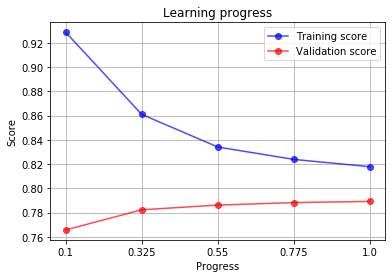

In [21]:
# XGBoost Classifier

# Features and target are defined
y = train.default_ind.values
X = train.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definiton and training
model = XGBClassifier(n_estimators=200,
                      max_depth=4,
                      learning_rate=0.05,
                      objective='binary:logistic',
                      scale_pos_weight=2.4794,
                      random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2)

ROC-AUC Score (no CV): 0.7014957290059375

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     11829
           1       0.56      0.59      0.57      4771

    accuracy                           0.75     16600
   macro avg       0.70      0.70      0.70     16600
weighted avg       0.75      0.75      0.75     16600



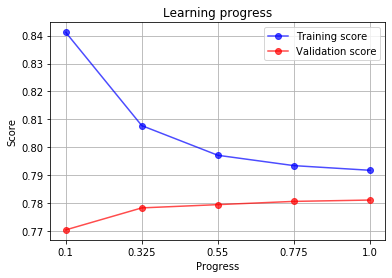

In [19]:
# LightGBM Classifier

# Features and target are defined
y = train.default_ind.values
X = train.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definition and training
model = LGBMClassifier(n_estimators=200,
                       max_depth=4,
                       learning_rate=0.05, 
                       objective='binary',
                       scale_pos_weight=2.4794,
                       random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2) 

### On zero imputed datasets
After imputation of datasets in `DataCleaning.ipynb` we will test the models above and see if any changes in performance are observed.

ROC-AUC Score (no CV): 0.7150680148689939

              precision    recall  f1-score   support

         0.0       0.86      0.73      0.79     11805
         1.0       0.51      0.70      0.59      4759

    accuracy                           0.72     16564
   macro avg       0.68      0.72      0.69     16564
weighted avg       0.76      0.72      0.73     16564



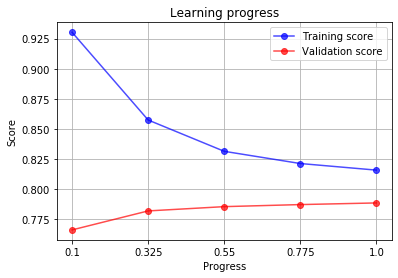

In [6]:
# XGBoost Classifier

# Features and target are defined
y = train.default_ind.values
X = train.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definiton and training
model = XGBClassifier(n_estimators=200,
                      max_depth=4,
                      learning_rate=0.05,
                      objective='binary:logistic',
                      scale_pos_weight=2.4794,
                      random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2)

### On missing forest imputed dataset
We expected somewhat better performance on missing forest imputed data.

ROC-AUC Score (no CV): 0.7111619764197022

              precision    recall  f1-score   support

         0.0       0.85      0.74      0.79     11753
         1.0       0.51      0.68      0.59      4740

    accuracy                           0.72     16493
   macro avg       0.68      0.71      0.69     16493
weighted avg       0.76      0.72      0.73     16493



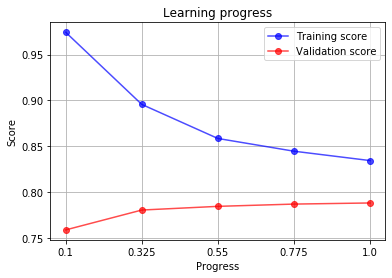

Training CV score: 0.9745
Validation CV score: 0.7585


In [14]:
# XGBoost Classifier

# Features and target are defined
y = train_mf.default_ind.values
X = train_mf.drop(['application_key', 'default_ind'], axis=1).values

# Split into train and evaluation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Model definiton and training
model = XGBClassifier(n_estimators=200,
                      max_depth=5,
                      learning_rate=0.05,
                      objective='binary:logistic',
                      scale_pos_weight=2.4794,
                      random_state=123)

model.fit(X_train, y_train)

# Prediction
preds = model.predict(X_val)

# Scoring
score = roc_auc_score(y_val, preds)
print("ROC-AUC Score (no CV): {}".format(score))
print('')
print(classification_report(y_val, preds))

# Show learning progress
learn_progress(model, X, y, res=5, scoring='roc_auc', cv=2)

## Training CNN over c-maps
Over the c-maps generated in the EDA notebook, we will now train a network having convolution, max pooling and dense layers. This method is experimental, quality of results is not predictable. 

**Code not functional right now**

In [12]:
# Get paths for all cmaps from directory

img_paths = glob('/home/nishant/Desktop/IDA Project/cmaps/*.0')

In [13]:
# Define the model class

class Network(torch.nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
        
        # Convolution layers
        self.C1 = torch.nn.Conv2d(3, 8, 5)
        self.C2 = torch.nn.Conv2d(8, 16, 3)
        self.C3 = torch.nn.Conv2d(16, 32, 3)
        self.C4 = torch.nn.Conv2d(32, 64, 3)
        
        # Max pooling layers
        self.MP1 = torch.nn.MaxPool2d(2)
        self.MP2 = torch.nn.MaxPool2d(2)
        self.MP3 = torch.nn.MaxPool2d(4)
        self.MP4 = torch.nn.MaxPool2d(2)
        
        # Linear layers 
        self.L1 = torch.nn.Linear(704, 128)
        self.L2 = torch.nn.Linear(128, 32)
        self.L3 = torch.nn.Linear(32, 8)
        self.L4 = torch.nn.Linear(8, 1)
        
        # Activations
        self.ReLU = torch.nn.ReLU()
        self.Sigmoid = torch.nn.Sigmoid()
        
    
    def forward(self, X):
        
        X = self.C1(X); X = self.MP1(X)
        X = self.C2(X); X = self.MP2(X)
        X = self.C3(X); X = self.MP3(X)
        X = self.C4(X); X = self.MP4(X)
        
        X = X.view(X.size(0), -1)
        X = self.L1(X); X = self.ReLU(X)
        X = self.L2(X); X = self.ReLU(X)
        X = self.L3(X); X = self.ReLU(X)
        X = self.L4(X); X = self.Sigmoid(X)
        
        return X

In [14]:
# Compile network and define loss 

net = Network()
loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(), lr=1e-3)

In [15]:
# Preparing training and validation data
# Select 5000 images of each type

root = '/home/nishant/Desktop/IDA Project/cmaps/'

keys_0 = train.loc[train.default_ind==0, 'application_key'].values[:2000]
targs_0 = np.zeros((2000, 1))
imgs_0 = []
    
keys_1 = train.loc[train.default_ind==1, 'application_key'].values[:2000]
targs_1 = np.ones((2000, 1))
imgs_1 = []

for i in range(len(keys_0)):
    clear_output()
    print("Now processing %d of %d" % (i, len(keys_0)))
    path_0, path_1 = root + str(keys_0[i]), root + str(keys_1[i])
    img_0, img_1 = cv2.imread(path_0), cv2.imread(path_1)
    img_0, img_1 = cv2.resize(img_0, (39, 25)), cv2.resize(img_1, (39, 25))
    imgs_0.append(img_0)
    imgs_1.append(img_1)

Now processing 1999 of 2000


In [16]:
# Splitting 80-20 into training and evaluation
# Then converting into torch tensors

X_train = np.array(imgs_0[:1500] + imgs_1[:1500], dtype=np.float32)
X_val = np.array(imgs_0[1500:] + imgs_1[1500:], dtype=np.float32)
y_train = np.array(1500*[0] + 1500*[1], dtype=np.float32)
y_val = np.array(500*[0] + 500*[1], dtype=np.float32)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)